<a href="https://colab.research.google.com/github/liirusuk/llm_train/blob/main/Week_1_practice_Intro_to_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to ML from an LLM standpoint
# Week 1. Practice session

In this notebook, we'll start exploring LLM APIs, their capabilities and their failures.

The platforms we’ll be using are:

- OpenAI API (https://platform.openai.com/): This provides access to GPT models like GPT-4. You can generate an API key here: [OpenAI API Keys](https://platform.openai.com/settings/organization/api-keys) (this page will only be available after you register).
- Nebius AI Studio (https://studio.nebius.ai/): This platform offers open-source LLMs from families such as Llama, Mistral, Qwen, and Gemma. Generate your API key here: [Nebius API Keys](https://studio.nebius.ai/settings/api-keys) (this page will only be available after you register).

An API key is just a string (usually, a long one). Each platform will only show you your API key once when it’s generated, so be sure to copy it and save it securely. If you lose your API key, you'll be able to generate a new one (but in this case, don't forget to invalidate the old one on a platform).
To set up for the class, please save the OpenAI API key in a file named `openai_api_key` (no file extension) and the Nebius API key in a file named `nebius_api_key` (also no file extension). Then load them both to colab.

We aim to explore close-to-production use of LLMs, so we start with APIs, but of course every LLM has its own playground:

- Feel free to play with OpenAI models here: https://chatgpt.com/.
- Nebius AI Studio's playground is here: https://studio.nebius.ai/playground.

# **Setting up**

Let's install the `openai` library (the `-q` flag saves us from reading the outputs) and get the API keys.

In [ ]:
!pip install -q openai

In [ ]:
import os

with open("openai_api_key", "r") as file:
    openai_api_key = file.read().strip()

os.environ["OPENAI_API_KEY"] = openai_api_key

with open("nebius_api_key", "r") as file:
    nebius_api_key = file.read().strip()

os.environ["NEBIUS_API_KEY"] = nebius_api_key

In [ ]:
# If you need to check which is Jupyter's directory:
!pwd

/content


# **Trying OpenAI and Nebius AI Studio**

## OpenAI API

Let's call GPT-4o-mini using chat interface of OpenAI API.

The text passed to an LLM is usually called a **prompt** and the LLM's output is known as **completion** (or response).

With `openai` library you can pass more than a prompt to the API. The messages parameter takes a list of messages with several possible roles, among them:

- `"user"`, that's you.
- `"assistant"`, a model's cue.
- `"system"` used to pass our wishes regarding the assistant's tone of voice, restrictions etc.

In [ ]:
import openai

# Choosing which LLM to call
# More models here: https://platform.openai.com/docs/models
MODEL = "gpt-4o-mini"
completion = openai.chat.completions.create(
    model=MODEL,
    messages=[
        {
            "role": "system",
            "content": "You are an expert software engineer."
        },
        {
            "role": "user",
            "content": """The following Python implementation of the QuickSort algorithm contains a bug.
                          Find the bug and correct the code:
                          def quicksort(arr):
                              if len(arr) <= 1:
                                  return arr
                              pivot = arr[0]
                              left = [x for x in arr if x < pivot]
                              right = [x for x in arr if x >= pivot]
                              return quicksort(left) + [pivot] + quicksort(right)
                          """},
    ]
)
print(completion.to_json())

{
  "id": "chatcmpl-AQJ0Sbpz9lsjBu1qNk162QQq9zZYM",
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "The bug in the provided QuickSort implementation occurs in how the `right` list is constructed. The condition for `right` should include elements that are **greater than or equal to** the pivot, which is correct; however, it inadvertently includes the pivot itself in both the `left` and `right` lists, which may lead to incorrect sorting behavior. This could lead to duplicates of the pivot in the construction of the final sorted array.\n\nTo fix this, you need to ensure that the pivot is not included in the `right` list when constructing the `left` and `right` partitions. You can adjust the implementation as follows:\n\n```python\ndef quicksort(arr):\n    if len(arr) <= 1:\n        return arr\n    pivot = arr[0]\n    left = [x for x in arr[1:] if x < pivot]  # Exclude pivot from left\n    right = [x for x

The `completion` variable contains much information; to extract only the completion, use:

In [ ]:
print(completion.choices[0].message.content)

The provided QuickSort implementation has a bug in how it partitions the array. Specifically, when partitioning the array, the implementation includes elements that are equal to the pivot in the `right` sub-array. This means that when all elements are equal to the pivot, it could lead to an infinite recursion because the pivot value will never reduce the size of the array effectively.

To fix this, we can adjust the partitioning logic. One common approach is to store elements that are equal to the pivot (which can be placed in the `right` sub-array) separately or simply modify the partitioning condition to handle duplicates appropriately.

Here’s the corrected version of the QuickSort function:

```python
def quicksort(arr):
    if len(arr) <= 1:
        return arr
    pivot = arr[0]
    
    left = [x for x in arr[1:] if x < pivot]  # Exclude pivot element itself from left
    right = [x for x in arr[1:] if x >= pivot]  # Exclude pivot element itself from right
    
    return quickso

Input and output tokens are the base for LLM API billing. For example, this is from the Nebius AI Studio model reference:

<center>
<img src="https://drive.google.com/uc?export=view&id=1w9IkQ4hmwqFqYbLiXlu0iNIfm2l7Vrem" width=1000 />
</center>


If you want to continue the discussion, you can just augment the `messages` variable:

```
messages=[
        {
            "role": "system",
            "content": <system prompt>
        },
        {
            "role": "user",
            "content": <user's first line>
        },
        {
            "role": "assistant"
            "content": <LLM's answer>
        },
        {
            "role": "user"
            "content": <user's second line>
        }
    ]
```

But each LLM has **max context length**, which is the maximal sum of lengths of all messages the LLM is going to process. For GPT-4o-mini it's 128k tokens. After max context length, the first messages will be ignored.

A short reference for you about the lengths of various data (with the tokenizer of Llama-3-8B; see details below).

| Text  | n_okens  |
|----------|----------|
| [Text2text\_generation.py from Transformers](https://github.com/huggingface/transformers/blob/main/src/transformers/pipelines/text2text_generation.py)   | 3.5k   |
| [xLSTM paper .tex file](https://arxiv.org/abs/2405.04517)    | 39k  |
| Harry Potter and the Philosopher's Stone | 109K |
| [UK Energy Act 2023](https://www.legislation.gov.uk/ukpga/2023/52/contents)   | 248k   |
| Lord of the Rings | 500K |
| Langchain github repo | 5.2M |
| Pytorch github repo | 28M |

## Nebius API

Now, let's call Llama-3.1-405B with a Nebius API.

The `max_tokens` parameter says how long can the completion be; after `max_tokens` tokens it's just cut short. It's not the same as saying `"answer in not more than 200 tokens"` in the prompt! This doesn't influence the generating process, just puts a cap on how many tokens we actually generate.

In [ ]:
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

# Which LLM to use
# For more models, see https://docs.nebius.com/studio/inference/models/
MODEL = "meta-llama/Meta-Llama-3.1-405B-Instruct"
completion = client.chat.completions.create(
    model=MODEL,
    messages=[
    {
        "role": "system",
        "content": """You're an expert software engineer."""
    },
    {
        "role": "user",
        "content": """Create a Python code that would produce a visualization of how regression curve depends on its training data.
                      There should be three subplots, each showing:
                      - The full training data,
                      - The part of the training data used to train current quadratic model,
                      - The true quadratic regression curve,
                      - The trained regression curve.
                      Choose very different parts of the training data for each model, like only left points, only right points, only outliers."""
    },
    ],
    temperature=0.6,
    max_tokens=1024,
    top_p=0.9
)

print(completion.to_json())

{
  "id": "chat-6da9c9da93ed47428d74cc7d88f5f2eb",
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Below is an example Python code that uses matplotlib for visualization and numpy for numerical computations. This code will generate a quadratic regression curve based on different subsets of the training data.\n\n```python\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.linear_model import LinearRegression\n\n# Generate training data\nnp.random.seed(0)\nx = np.linspace(-10, 10, 100)\ny = x**2 + np.random.normal(0, 20, 100)\n\n# Create subsets of the training data\nx_left = x[x < 0]\ny_left = y[x < 0]\n\nx_right = x[x > 0]\ny_right = y[x > 0]\n\nx_outliers = np.concatenate((x[x < -8], x[x > 8]))\ny_outliers = np.concatenate((y[x < -8], y[x > 8]))\n\n# Function to train a quadratic regression model\ndef train_quadratic_model(x_train, 

Extracting the completion:

In [ ]:
print(completion.choices[0].message.content)

Below is an example Python code that uses matplotlib for visualization and numpy for numerical computations. This code will generate a quadratic regression curve based on different subsets of the training data.

```python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Generate training data
np.random.seed(0)
x = np.linspace(-10, 10, 100)
y = x**2 + np.random.normal(0, 20, 100)

# Create subsets of the training data
x_left = x[x < 0]
y_left = y[x < 0]

x_right = x[x > 0]
y_right = y[x > 0]

x_outliers = np.concatenate((x[x < -8], x[x > 8]))
y_outliers = np.concatenate((y[x < -8], y[x > 8]))

# Function to train a quadratic regression model
def train_quadratic_model(x_train, y_train):
    x_train = x_train.reshape(-1, 1)
    poly_features = PolynomialFeatures(degree=2)
    x_train_poly = poly_features.fit_transform(x_train)
    model = LinearRegression()
    model.fit(x_train_pol

Running the code:

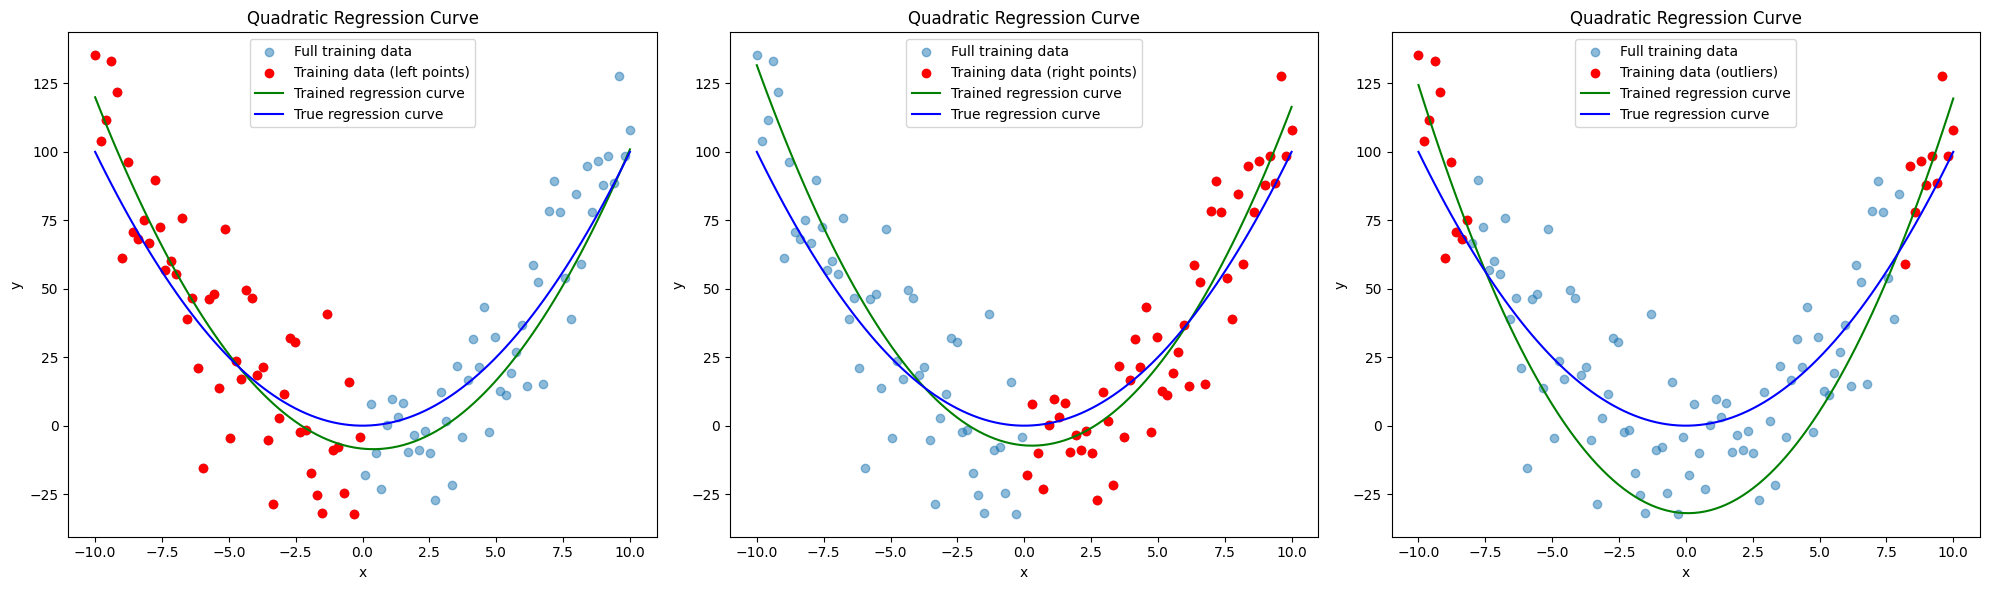

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Generate training data
np.random.seed(0)
x = np.linspace(-10, 10, 100)
y = x**2 + np.random.normal(0, 20, 100)

# Create subsets of the training data
x_left = x[x < 0]
y_left = y[x < 0]

x_right = x[x > 0]
y_right = y[x > 0]

x_outliers = np.concatenate((x[x < -8], x[x > 8]))
y_outliers = np.concatenate((y[x < -8], y[x > 8]))

# Function to train a quadratic regression model
def train_quadratic_model(x_train, y_train):
    x_train = x_train.reshape(-1, 1)
    poly_features = PolynomialFeatures(degree=2)
    x_train_poly = poly_features.fit_transform(x_train)
    model = LinearRegression()
    model.fit(x_train_poly, y_train)
    return model

# Train models on different subsets of the training data
model_left = train_quadratic_model(x_left, y_left)
model_right = train_quadratic_model(x_right, y_right)
model_outliers = train_quadratic_model(x_outliers, y_outliers)

# Create a range of x values for plotting the regression curves
x_plot = np.linspace(-10, 10, 100).reshape(-1, 1)
poly_features = PolynomialFeatures(degree=2)
x_plot_poly = poly_features.fit_transform(x_plot)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Plot full training data
for ax in axs:
    ax.scatter(x, y, label='Full training data', alpha=0.5)

# Plot subsets of the training data and regression curves
axs[0].scatter(x_left, y_left, label='Training data (left points)', color='red')
axs[0].plot(x_plot, model_left.predict(x_plot_poly), label='Trained regression curve', color='green')
axs[0].plot(x_plot, x_plot**2, label='True regression curve', color='blue')

axs[1].scatter(x_right, y_right, label='Training data (right points)', color='red')
axs[1].plot(x_plot, model_right.predict(x_plot_poly), label='Trained regression curve', color='green')
axs[1].plot(x_plot, x_plot**2, label='True regression curve', color='blue')

axs[2].scatter(x_outliers, y_outliers, label='Training data (outliers)', color='red')
axs[2].plot(x_plot, model_outliers.predict(x_plot_poly), label='Trained regression curve', color='green')
axs[2].plot(x_plot, x_plot**2, label='True regression curve', color='blue')

# Set labels and titles
for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Quadratic Regression Curve')
    ax.legend()

plt.tight_layout()
plt.show()

# Multimodal input

Modern LLMs also increasingly incorporate other modalities, usually Images. We can see that represented in OpenAI APIs. Let's try to feed the above plot to the API and see what it thinks about it.

In [ ]:
import base64

IMAGE_PATH = 'regression.png'
MODEL = 'gpt-4o'

# Open the image file and encode it as a base64 string
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

base64_image = encode_image(IMAGE_PATH)

completion = openai.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": [
            {"type": "text", "text": "What is depicted on the picture?"},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_image}"}
            }
        ]}
    ]
)

print(completion.choices[0].message.content)

The image depicts a scatter plot with a regression analysis. The components include:

- Gray dots representing the "Full training data."
- Blue dots representing the "Training data for Left points."
- A green curve labeled "True regression curve."
- A red curve labeled "Trained regression curve."

The plot visualizes the comparison between the true regression curve and the trained regression curve based on the provided data points.


In [ ]:
base64_image[:100]

'iVBORw0KGgoAAAANSUhEUgAAAkwAAAH4CAYAAAC417I9AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwg'

# Tokenization

Before going into the LLM, the prompt is **tokenized**, that is, split into **tokens**. And the completion is also generated **token by token**.

<center>
<img src="https://drive.google.com/uc?export=view&id=1nKMwN3nZ9ZoEQcdzhxmv5QPXLHv6K7MK" width=600 />
</center>

As you see, the words are cut into pieces called **subword units**. Why? This allows to:

- Have a dictionary (list of all tokens) of fixes size. This wouldn't work with **word-level** tokeinization: typos and neologisms would make the dictionary too huge.
- Have meaningful tokens, unlike in **character-level** tokenization.

**Note**. Some LLMs use hybrid strategy, where `import pandas as pd` may be one token.

Let's try the OpenAI tokenizer. For that, we need the `tiktoken` library.

In [ ]:
!pip install -q tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.8 MB/s eta 0:00:00


In [ ]:
import tiktoken

encoding = tiktoken.encoding_for_model('gpt-4o-mini')

Now, let's tokenize a simple prompt.

In [ ]:
initial_string = 'Darth Vader was born on Tatooine.'

# Tokenization
encoded_string = encoding.encode(initial_string)
print('After tokenization (encoded string): ', encoded_string)

# Tokenization
print('Decoding back: ', encoding.decode(encoded_string))

# Decoding each token:
for token in encoded_string:
    print(f'{token}: {encoding.decode([token])}')

After tokenization (encoded string):  [35, 7087, 120316, 673, 12275, 402, 353, 2754, 58552, 13]
Decoding back:  Darth Vader was born on Tatooine.
35: D
7087: arth
120316:  Vader
673:  was
12275:  born
402:  on
353:  T
2754: ato
58552: oine
13: .


Also feel free to try this:

In [ ]:
python_code = """import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {'values': [10, 20, 20, 30, 30, 30, 40, 40, 50]}
df = pd.DataFrame(data)

# Plotting the histogram
plt.hist(df['values'], bins=5, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()"""

# Tokenization
encoded_string = encoding.encode(python_code)

# Decoding each token:
for token in encoded_string:
    print(f'{token}: {encoding.decode([token])}')

## Tokenization consequences

LLMs don't naturally see the text on a character level, and it is one of the reasons why LLMs are not so good at arithmetics, reversing strings and similar tasks.

Let's look at several examples.

In [ ]:
initial_string = '12345678'

# Tokenization
encoded_string = encoding.encode(initial_string)
print('After tokenization (encoded string): ', encoded_string)

# Decoding each token:
for token in encoded_string:
    print(f'{token}: {encoding.decode([token])}')

After tokenization (encoded string):  [7633, 19354, 4388]
7633: 123
19354: 456
4388: 78


# Some additional API features

## 1. Prompt caching

Prompt caching allows you to reuse you prompt's **prefix** if it was already present in previous request. This potentially saves a lot of computations.

<center>
<img src="https://openaidevs.retool.com/api/file/8593d9bb-4edb-4eb6-bed9-62bfb98db5ee" width=600 />
</center>

[Source](https://platform.openai.com/docs/guides/prompt-caching)

See the details for OpenAI's prompt caching [here](https://platform.openai.com/docs/guides/prompt-caching).

Let's try it in OpenAI API:

In [ ]:
import openai

# Choosing which LLM to call
# More models here: https://platform.openai.com/docs/models
MODEL = "gpt-4o-mini"

prompt = """You are designing a scalable e-commerce platform for an online retailer that expects high traffic and a large product catalog. The primary features include user accounts, product browsing, a shopping cart, secure checkout, and an order management system. The platform needs to support both desktop and mobile clients and should be able to handle up to 500,000 concurrent users at peak times, such as during holiday sales.

    Architecture: Describe a high-level architecture for this platform using microservices. Explain how you would structure services such as user management, product catalog, shopping cart, checkout, and order fulfillment. Consider which services would require persistent storage, what kind of databases would be most suitable, and how you would ensure data consistency across services. Consider whether an event-driven architecture would help manage workflows, particularly for order fulfillment, and provide details on how services might communicate (e.g., REST, gRPC, or message queues).

    Data Management: Since the platform will have a large and diverse catalog, the product catalog service needs to be optimized for fast retrieval and scalability. Explain how you would design the database for this service, taking into account the need to support quick searches, filters, and product recommendations. Would you use a relational database, NoSQL, or a combination? How would you handle caching for high-demand products to reduce load on the database?

    Scalability and Load Balancing: Detail your approach for scaling the platform to handle high traffic. How would you implement load balancing across services, and what strategies would you use for horizontal scaling? Discuss auto-scaling policies, monitoring, and which metrics would help trigger scaling actions. Describe any CDNs you might use to optimize content delivery to users across different regions.

    Security: Outline the security practices you would enforce to protect user data and ensure secure transactions. Consider how you would implement authentication and authorization (e.g., OAuth2, JWT tokens). How would you secure sensitive information, such as payment details, and which encryption methods would you apply? Provide details on how you would set up monitoring and alerting to detect and respond to potential security incidents in real-time.

    Fault Tolerance and Resilience: Describe how you would build resilience into the platform to minimize downtime and ensure availability, even during partial failures. Would you use patterns like circuit breakers, retries, or bulkheads? Explain how you would handle failover between regions, particularly during traffic spikes, and discuss any disaster recovery strategies you’d implement.

    CI/CD and DevOps: Detail a CI/CD pipeline for deploying updates to the microservices. Explain how you would use containerization (e.g., Docker) and orchestration (e.g., Kubernetes) to manage service deployment and scaling. How would you handle versioning of services to allow for backward compatibility during updates? Describe how you would set up logging and monitoring for real-time insights into service health and system performance.

    Testing Strategy: With multiple services interacting, a robust testing strategy is crucial. Explain how you would approach testing each microservice in isolation and how you’d conduct integration testing across services. Would you use a test framework for end-to-end tests, and what tools would be effective for automating these tests? Detail any load testing strategies to ensure the platform can handle the expected traffic.

    Observability and Monitoring: Describe the observability stack you would set up to monitor the platform. Which metrics would you track for each service (e.g., latency, error rates, request rates), and how would you visualize these? How would you implement distributed tracing to follow requests across services, and what alerting rules would you put in place to quickly identify and respond to issues?

    Performance Optimization: Identify potential performance bottlenecks and how you would optimize them. For example, discuss how you would handle heavy read operations in the product catalog service, optimize database queries, and reduce latency in user-facing services. Would you use caching layers like Redis, or optimize network requests through batching or asynchronous processing?

    Feature Scaling: The company plans to add new features such as personalized recommendations, product reviews, and a loyalty program in the future. How would you ensure the architecture can accommodate these expansions without major rewrites? Describe any design principles or patterns (e.g., API Gateway, Command Query Responsibility Segregation) that would support scaling features efficiently.

    User Experience and API Design: Consider the user-facing side of the platform and how the APIs should be designed to provide a smooth experience on both web and mobile. Describe how you would structure the API endpoints for different features (e.g., product browsing, account management, checkout) to be both intuitive and performant. How would you handle rate limiting and error handling to prevent overloading the services while maintaining usability? Include any strategies for versioning the APIs to support future enhancements.

    Data Privacy and Compliance: The platform will operate in multiple regions, each with its own regulations (e.g., GDPR in Europe, CCPA in California). Explain how you would design the system to be compliant with data privacy laws, including how you would handle data storage, user consent, and data deletion requests. How would you ensure that personal information is stored and processed securely, and what role-based access controls would you implement to protect sensitive data?

    Analytics and Insights: The platform needs to track user behavior, purchase patterns, and other key metrics to generate insights for business decisions. Describe how you would collect and store analytics data, ensuring minimal impact on performance. What data processing and analytics tools would you use, and how would you integrate them with the platform? Would you consider real-time analytics, and if so, how would you handle large data volumes efficiently?

    Collaboration with Other Teams: Since this platform will involve contributions from multiple teams (e.g., front-end, back-end, DevOps, QA), outline a strategy for ensuring effective collaboration. How would you organize code repositories, documentation, and communication channels to keep the project cohesive and efficient? Would you implement code review processes, shared style guides, or other best practices to maintain quality across teams?

    Sustainability and Cost Management: Operating at scale can lead to high infrastructure costs. Describe how you would manage resource usage to control costs while maintaining performance. Would you use tools for automated cost tracking, and what policies would you implement to avoid over-provisioning? Discuss any strategies for optimizing server usage, leveraging spot instances, or using cloud services that match the platform’s needs efficiently."""

# Calculate how many tokens the prompt contains:
encoded_string = encoding.encode(prompt)
print(f"The prompt has {len(encoded_string)} tokens")

response = openai.chat.completions.create(
    model=MODEL,
    messages=[
        {
            "role": "system",
            "content": "You are an expert software architect."
        },
        {
            "role": "user",
            "content": prompt},
    ],
            max_tokens=64
)
print(response.to_json())

The prompt has 1284 tokens
{
  "id": "chatcmpl-APHkCUbfM9iI5hmbEGaZw3fPemIyS",
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Designing a scalable e-commerce platform involves multiple considerations across architecture, data management, scalability, security, fault tolerance, CI/CD, testing strategy, observability, performance optimization, feature expansion, user experience, data privacy, analytics, collaboration, and cost management. Here’s a comprehensive design:\n\n### Architecture\n\n1. **",
        "refusal": null,
        "role": "assistant"
      }
    }
  ],
  "created": 1730589772,
  "model": "gpt-4o-mini-2024-07-18",
  "object": "chat.completion",
  "system_fingerprint": "fp_0ba0d124f1",
  "usage": {
    "completion_tokens": 64,
    "prompt_tokens": 1302,
    "total_tokens": 1366,
    "completion_tokens_details": {
      "reasoning_tokens": 0
    },
    "prompt_tokens_details": {
      "

OpenAI API starts caching your prompt prefix after 1024 tokens with a 128 token step. In our case, 1152 = 1024 + 128 tokens were cached. Now, generation with the same prefix should be less expensive.

In [ ]:
# Calculate how many tokens the prompt contains:
encoded_string = encoding.encode(prompt)
print(f"The prompt has {len(encoded_string)} tokens")

response = openai.chat.completions.create(
    model=MODEL,
    messages=[
        {
            "role": "system",
            "content": "You are an expert software architect."
        },
        {
            "role": "user",
            "content": prompt + " It's important for my career!"},
    ],
            max_tokens=64
)
print(response.to_json())

The prompt has 1284 tokens
{
  "id": "chatcmpl-APHnET4SYWvLq8nBYkKWWIL47k0Py",
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "Designing a scalable e-commerce platform that anticipates high traffic and a large product catalog necessitates a well-thought-out microservices architecture, efficient data management, robust security practices, and strategies for scalability, performance optimization, observability, compliance, and collaboration among various teams. Below is a comprehensive approach to address each aspect",
        "refusal": null,
        "role": "assistant"
      }
    }
  ],
  "created": 1730589960,
  "model": "gpt-4o-mini-2024-07-18",
  "object": "chat.completion",
  "system_fingerprint": "fp_0ba0d124f1",
  "usage": {
    "completion_tokens": 64,
    "prompt_tokens": 1308,
    "total_tokens": 1372,
    "completion_tokens_details": {
      "reasoning_tokens": 0
    },
    "prompt_tokens_

## 2. Batch API

You don't always need the answers right here and right now. For example, a routine evaluation of your LLM-based service may wait for several hours. Batch API allows to get the completions for a batch of inputs cheaper at a cost of some waiting (up to 24h for OpenAI).

See more details about OpenAI's Batch API [here](https://platform.openai.com/docs/guides/batch).

## 3. Predicted outputs

That's a brand new feature in OpenAI API which appeared on November 4. It allows to speed up generation in case if some parts of the output are just repeating your input. A good example of a relevant task is code refactoring.

You can read more about this function in the official docs: https://platform.openai.com/docs/guides/latency-optimization?lang=python